In [37]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

from skimage import measure, morphology
from skimage.color import label2rgb
from skimage.measure import regionprops

from PIL import Image

from pdf2image import convert_from_bytes, convert_from_path

In [2]:
def show_image(img):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

In [3]:
def fileToImages(file_name):
    with open(file_name, 'rb') as file:
        pdf_test = file.read()
        images = convert_from_bytes(pdf_test)
        return images

In [4]:
def extract_sign(img, outlier_weight = 2.5, outlier_bias = 100, amplfier = 30, area_size = 10):
    condition = img > img.mean()
    labels = measure.label(condition, background=1)

    total_pixels = 0
    nb_region = 0
    average = 0.0
    for region in regionprops(labels):
        if (region.area > area_size):
            total_pixels += region.area
            nb_region += 1

    average = (total_pixels/nb_region)
    # small_size_outlier is used as a threshold value to remove pixels
    # are smaller than small_size_outlier
    small_size_outlier = average * outlier_weight + outlier_bias

    # big_size_outlier is used as a threshold value to remove pixels
    # are bigger than big_size_outlier
    big_size_outlier = small_size_outlier * amplfier

    # remove small pixels
    pre_version = morphology.remove_small_objects(labels, small_size_outlier)
    # remove the big pixels
    component_sizes = np.bincount(pre_version.ravel())
    too_small = component_sizes > (big_size_outlier)
    too_small_mask = too_small[pre_version]
    pre_version[too_small_mask] = 0
    
    return pre_version

# images

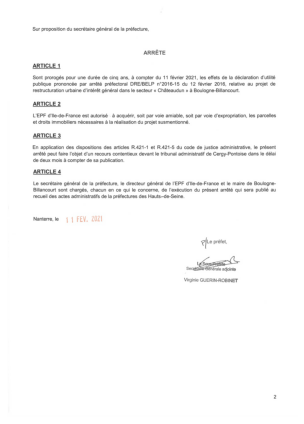

In [60]:
image = cv2.imread('./data/input/signed_image.jpeg')
show_image(image)

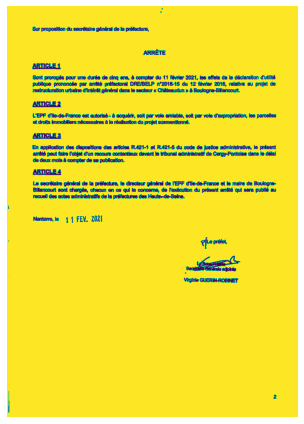

In [61]:
frame_HSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
frame_threshold = cv2.inRange(frame_HSV, (0, 0, 250), (255, 255, 255))
show_image(frame_threshold)

In [62]:
preview = extract_sign(frame_threshold, outlier_weight = 3, outlier_bias = 100, amplfier = 10)
plt.imsave('./data/output/signed_image.jpg', preview)

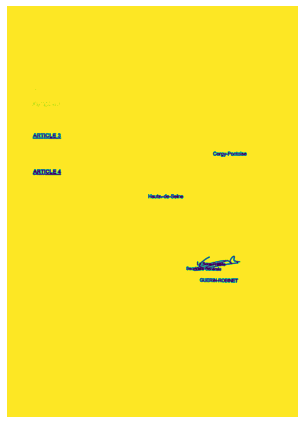

In [63]:
img = cv2.imread('./data/output/signed_image.jpg', 0)
# ensure binary
img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
show_image(img)

In [64]:
img

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [65]:
cnts = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnt = cnts[0] if len(cnts) == 2 else cnts[1]

[[732, 1022, 223, 64]]


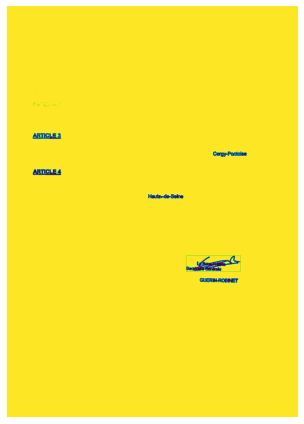

In [66]:
boxes = []
copy_img = img.copy()
for c in cnt:
    (x, y, w, h) = cv2.boundingRect(c)
    if h * w > 10000 and h < copy_img.shape[0] and w < copy_img.shape[1]:
        cv2.rectangle(copy_img,(x,y),(x+w,y+h),(155,155,0),1)
        boxes.append([x, y, w, h])
print(boxes)
show_image(copy_img)
plt.imsave('./data/output/signed_image_boxed.jpeg', copy_img)

In [67]:
np_boxes = np.array(boxes)

In [68]:
area_size = list(map(lambda box: box[2] * box[3], np_boxes))
area_size = np.array(area_size)
area_dec_order = area_size.argsort()[::-1]
area_dec_order

array([0])

In [69]:
sorted_boxes = np_boxes[area_dec_order]

In [70]:
def is_intersected(box_a, box_b) -> bool:
    [x_a, y_a, w_a, h_a] = box_a    
    [x_b, y_b, w_b, h_b] = box_b
    
    if y_a > y_b + h_b: return False
    if y_a + h_a < y_b: return False
    if x_a > x_b + w_b: return False
    if x_a + w_a < x_b: return False
    return True

In [71]:
def merge_boxes(box_a, box_b) -> list:
    [x_a, y_a, w_a, h_a] = box_a    
    [x_b, y_b, w_b, h_b] = box_b
    
    min_x = min(x_a, x_b)
    min_y = min(y_a, y_b)
    max_w = max(w_a, w_b, (x_b + w_b - x_a), (x_a + w_a - x_b))
    max_h = max(h_a, h_b, (y_b + h_b - y_a), (y_a + h_a - y_b))
    
    return [min_x, min_y, max_w, max_h]

In [72]:
regions = {}
for i, box in enumerate(sorted_boxes):
    if len(regions) == 0:
        regions[0] = box
    else:
        is_merged = False
        for key, region in regions.items():
            if is_intersected(region, box) == True:
                new_region = merge_boxes(region, box)
                regions[key] = new_region
                is_merged = True
                break
        if is_merged == False:
            key = len(regions)
            regions[key] = box

In [73]:
regions

{0: array([ 732, 1022,  223,   64])}

In [74]:
def draw_regions(img, regions):
    cwd = os.getcwd()
    
    for key, region in regions.items():
        copy_img = Image.fromarray(img)
        [x, y, w, h] = region
        
        crop = copy_img.crop((x, y, x + w, y + h))
        crop.save(cwd + '/data/output/signed_image_region_{}.jpeg'.format(key), 'JPEG')

In [75]:
draw_regions(img, regions)

# PDF

In [41]:
images = convert_from_path('./data/input/signed_file.pdf')
print(len(images))

2


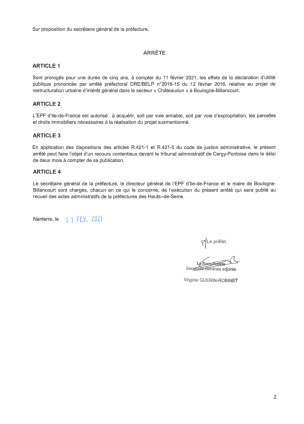

In [43]:
show_image(images[1])